In [6]:
import sys
from pathlib import Path
import numpy as np
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from pandas.core.common import flatten
from IPython.display import display
import json
import shutil, tarfile
from timeit import default_timer as timer
from make_logfile_df import make_logfile_df

# path to the python file
# p = Path(__file__).parent

#user dependent paths
home = Path.home()
homew = Path('/mnt/c/Users/akandra')
ownCloud = homew / 'ownCloud'
datapath = home /  'kmc_tmp'
gz_datapath = ownCloud / "Kinetic Monte Carlo/data_analysis/O-Pt"

In [4]:
home

PosixPath('/home/akandra')

In [9]:
# Get list of folders with data by searching for log-files
#datapath = Path("/home/akandra/calculations/O_Pt/phase_diagram")
#logfiles = list(datapath.glob('*/*.log'))
#datadirs = [f.parent for f in logfiles]

# Define folders with compressed trajectory data
#gz_datapath = Path("/home/akandra/ownCloud/Projects/Kinetic Monte Carlo/data_analysis/O-Pt")
dirs = ["gc-phase-diagram-0", 
        "grand-potential", 
        "phase-diagram-fine-grid", 
        "phase-diagram-finer-grid", 
        "inicov03"]
#dirs = ["grand-potential"]
gz_datadirs = [gz_datapath / d for d in dirs]

# datapath = Path("/home/akandra/kmc-tmp")
datapath.mkdir(exist_ok=True)
print('datapath=',datapath)
datadirs = [datapath / d for d in dirs]

for d in dirs:
    try:
        (datapath / d).mkdir()
    except FileExistsError:
        print(f'folder {d} exists.')
    else:
        [ shutil.copy(f, datapath / d / f.name ) for f in (gz_datapath / d).glob('*.log') ]
        [ shutil.copy(f, datapath / d / f.name ) for f in (gz_datapath / d).glob('*.energy') ]
        for f in (gz_datapath / d).glob('*.gz'):
            with tarfile.open(f, "r") as tf:
                print('Extracting files from '+f.parts[-2]+'/'+f.name+'...' ,end='')
                tf.extractall(path=datapath / d)
                print('done')

logfiles = [ list(d.glob('*.log'))[0] for d in datadirs]

datapath= /home/akandra/kmc_tmp
Extracting files from gc-phase-diagram-0/o-pt-mmc-gc.tar.gz...

/tmp/ipykernel_97193/3436770063.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(path=datapath / d)


done
Extracting files from grand-potential/o-pt-mmc-gc.tar.gz...done
Extracting files from phase-diagram-fine-grid/o-pt-mmc-gc.tar.gz...done
Extracting files from phase-diagram-finer-grid/o-pt-mmc-gc.tar.gz...done
Extracting files from inicov03/o-pt-mmc-gc.tar.gz...done


In [10]:

#------------------------------------------
# create DataFrame and col_names list
#------------------------------------------
df = pd.DataFrame()
for logfile in logfiles:    
    df = pd.concat([df, make_logfile_df(logfile)])
    df['ncells'] = df['nLat_0']*df['nLat_1']

#    print('\n------------------------\ndata frame with header')
#    display(df)

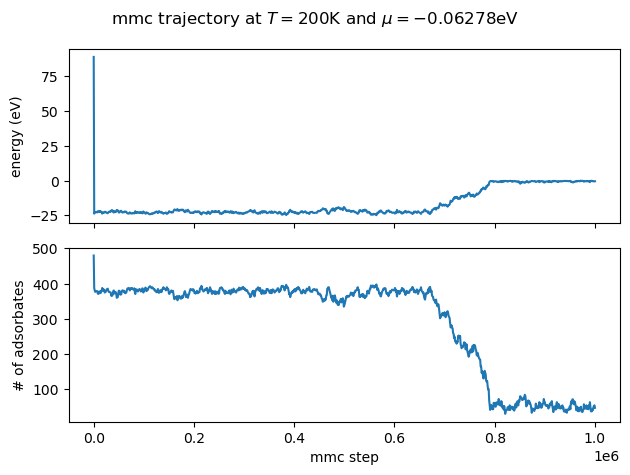

In [11]:
#Plot a single trajectory to see when equilibration finished
Toi = 200
muoi = -0.06278
run_id_ndigits = 4
try:
    run_id,lfile = df.loc[(df['Temp'] == Toi) & (df['gc_chempots_0'] == muoi), 
                          ['run','logfile_name'] ].iloc[0]
except:
    print(f'No mmc trajectory for T={Toi}K and mu={muoi}eV')
else:
    enfile = lfile.with_stem(lfile.stem + '-' + str(run_id).zfill(run_id_ndigits)).with_suffix(".en")
    with open(enfile,'r') as f:
        step,energy,nads = np.loadtxt(f,skiprows=1).transpose()

    fig, axis = plt.subplots(2,sharex=True)
    fig.suptitle(fr'mmc trajectory at $T={Toi}$K and $\mu={muoi}$eV')

    axis[0].set_ylabel("energy (eV)")
    axis[0].plot(step, energy)
    #axis[0].set_xlim([0,1000000])
    #axis[0].set_ylim([max(energy)-20,max(energy)+1])

    axis[1].set_ylabel("# of adsorbates")
    axis[1].plot(step, nads)
    #axis[1].set_ylim([max(nads)-250,max(nads)+1])

    for ax in axis:
        ax.set_xlabel(r'mmc step')
        ax.label_outer()
    fig.tight_layout()

    plt.show()

In [12]:
# Reading in trajectories and calculate averages
start_eq = -500

cov_av    = np.zeros(len(df))
cov_var   = np.zeros(len(df))
cov_span  = np.zeros(len(df))
energy_av = np.zeros(len(df))
times = np.zeros(3)
run_id_ndigits = 4
for index in range(len(df)):
    lfile = df['logfile_name'].iloc[index]
    run_id = df['run'].iloc[index]
    ncells = df['ncells'].iloc[index]
    enfile = lfile.with_stem(lfile.stem + '-' + str(run_id).zfill(run_id_ndigits)).with_suffix(".en")
    with open(enfile,'r') as f:
        t1 = timer()
        step,energy,nads = np.loadtxt(f,skiprows=1).transpose()
        t2 = timer()
        times[0] += t2 - t1
        t1 = timer()
        cov_av[index]  = nads[start_eq:].mean()/ncells
        cov_var[index] = nads[start_eq:].var()/(ncells**2)
        cov_span[index]= (nads[start_eq:].max() - nads[start_eq:].min())/ncells
        energy_av[index] = energy[start_eq:].mean()/ncells
        times[1] += t1 - t2

t1 = timer()
df['coverage'] = cov_av
df['energy']   = energy_av
df['cov_var']  = cov_var
df['cov_span'] = cov_span
times[2] = timer() - t1

print(f"{len(df)} trajectories processed.")
print(f"It took {np.sum(times):.2f} seconds:")
print(f' {times[0]:.2f}s to load files')
print(f' {times[1]:.2f}s to get averages')
print(f' {times[2]:.2f}s to add them to df')

31658 trajectories processed.
It took 10.15 seconds:
 10.08s to load files
 0.06s to get averages
 0.00s to add them to df


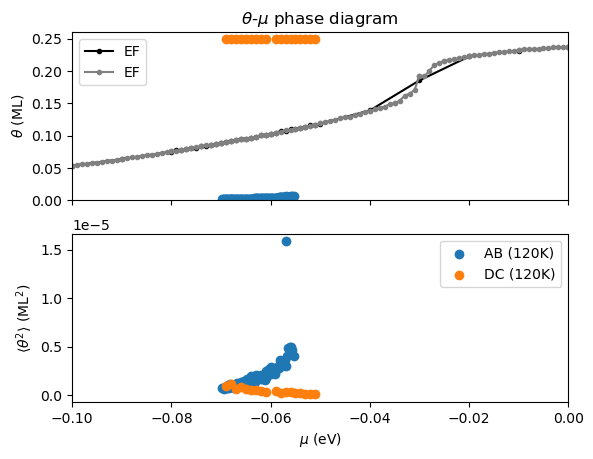

In [13]:

fig, axis = plt.subplots(2,1,sharex=True)
Toi = [120]
Tref = 450
axis[0].set_title(fr'$\theta$-$\mu$ phase diagram')
axis[0].set_xlabel(fr"$\mu$ (eV)")
axis[0].set_ylabel(fr"$\theta$ (ML)")
#axis[0].set_xlim(-.064,-.06)
axis[0].set_xlim(-.1,-.0)
axis[0].set_ylim(.0,.26)
axis[1].set_xlabel(fr"$\mu$ (eV)")
axis[1].set_ylabel(fr"$\langle\theta^2\rangle$ (ML$^2$)")

for i,T in enumerate(Toi):
    dfs = df.loc[(df["Temp"] == T)].sort_values('gc_chempots_0')

    mu_AB  = dfs[(dfs["cov_0"]==0.01) & (dfs["coverage"]<0.125)].gc_chempots_0
    cov_AB = dfs[(dfs["cov_0"]==0.01) & (dfs["coverage"]<0.125)].coverage
    cov2_AB =dfs[(dfs["cov_0"]==0.01) & (dfs["coverage"]<0.125)].cov_var
    axis[0].scatter(mu_AB,cov_AB)
    axis[1].scatter(mu_AB,cov2_AB, label=f"AB ({T}K)")

    df_DC  = dfs[(dfs["cov_0"]==0.3)
                & (dfs["coverage"]>0.125) 
                & (dfs["cov_span"]<0.04)
                ]
    axis[0].scatter(df_DC['gc_chempots_0'],df_DC['coverage'])
    axis[1].scatter(df_DC['gc_chempots_0'],df_DC['cov_var'],label=f"DC ({T}K)")

df_EF = df.loc[(df["Temp"] == Tref)&(df["cov_0"]==0.3)].sort_values('gc_chempots_0')
axis[0].plot(df_EF.gc_chempots_0,df_EF.coverage, marker='.',color='black', label="EF")
df_EF = df.loc[(df["Temp"] == Tref)&(df["cov_0"]==0.01)].sort_values('gc_chempots_0')
axis[0].plot(df_EF.gc_chempots_0,df_EF.coverage, marker='.',color='grey', label="EF")

for ax in axis:
    ax.label_outer()
    ax.legend()

plt.tight_layout
plt.show()

In [14]:
def count_Ts(df,mu,cov_0):
    return len(df.loc[(df['gc_chempots_0']==mu)&
                      (df['cov_0']==cov_0)]['Temp'].unique())

sorted([(mu,count_Ts(df,mu,0.01)) for mu in 
                df.loc[(df['Temp']==100)]['gc_chempots_0'].unique()],
       key=lambda x: x[1],reverse=True)

[(np.float64(0.0), 79),
 (np.float64(-0.1), 79),
 (np.float64(-0.035), 64),
 (np.float64(-0.04), 64),
 (np.float64(-0.036), 64),
 (np.float64(-0.038), 64),
 (np.float64(-0.037), 64),
 (np.float64(-0.031), 64),
 (np.float64(-0.032), 64),
 (np.float64(-0.033), 64),
 (np.float64(-0.039), 64),
 (np.float64(-0.034), 64),
 (np.float64(-0.041), 64),
 (np.float64(-0.042), 64),
 (np.float64(-0.043), 64),
 (np.float64(-0.044), 64),
 (np.float64(-0.045), 64),
 (np.float64(-0.046), 64),
 (np.float64(-0.047), 64),
 (np.float64(-0.05), 64),
 (np.float64(-0.048), 64),
 (np.float64(-0.049), 64),
 (np.float64(-0.051), 64),
 (np.float64(-0.053), 64),
 (np.float64(-0.052), 64),
 (np.float64(-0.054), 64),
 (np.float64(-0.055), 64),
 (np.float64(-0.056), 64),
 (np.float64(-0.057), 64),
 (np.float64(-0.058), 64),
 (np.float64(-0.059), 64),
 (np.float64(-0.06), 64),
 (np.float64(-0.061), 64),
 (np.float64(-0.062), 64),
 (np.float64(-0.063), 64),
 (np.float64(-0.064), 64),
 (np.float64(-0.065), 64),
 (np.floa

In [15]:
# Functions defining Grand potentials along thermodynamic intergration path

def Omega_B(mu_ul,mudataAB,covdataAB):
    # Find coverage at lower and upper limits,
    # do interpolation if necessary
    if ((mu_ul < mudataAB[0]) or (mu_ul > mudataAB[-1])):
        sys.exit(f"mu_ul = {mu_ul} in Omega_B is out of range ({mudataAB[0]:0.5f},{mudataAB[-1]:0.5f})")

    try:
        imax = np.where(mudataAB == mu_ul)[0][0]
        mudata  =  mudataAB[:imax]
        covdata = covdataAB[:imax]
    except:
        imax = np.where(mudataAB < mu_ul)[0][-1]
        slope = (covdataAB[imax+1] - covdataAB[imax])\
            /(mudataAB[imax+1] - mudataAB[imax])
        cov_ul  = covdataAB[imax] + slope*(mu_ul - mudataAB[imax])
        mudata  = np.append( mudataAB[:imax], mu_ul)
        covdata = np.append(covdataAB[:imax],cov_ul)

    return -np.trapz(covdata, mudata)

def Omega_E(mu_ll,TdataAE,endataAE,covdataAE):
    return -TdataAE[-1]*np.trapz((endataAE - mu_ll*covdataAE)/(TdataAE*TdataAE), TdataAE)

def Omega_F(mu_ll,mu_ul,TdataAE,endataAE,covdataAE,mudataEF,covdataEF):
    # Find coverage at lower and upper limits,
    # do interpolation if necessary
    if ((mu_ul < mudataEF[0]) or (mu_ul > mudataEF[-1])):
        sys.exit(f"mu_ul = {mu_ul} in Omega_F is out of range ({mudataEF[0]:0.5f},{mudataEF[-1]:0.5f})")

    try:
        imax = np.where(mudataEF == mu_ul)[0][0]
        mudata  =  mudataEF[:imax]
        covdata = covdataEF[:imax]
    except:
        imax = np.where(mudataEF < mu_ul)[0][-1]
        slope = (covdataEF[imax+1] - covdataEF[imax])\
            /(mudataEF[imax+1] - mudataEF[imax])
        cov_ul  = covdataEF[imax] + slope*(mu_ul - mudataEF[imax])
        mudata  = np.append( mudataEF[:imax], mu_ul)
        covdata = np.append(covdataEF[:imax],cov_ul)

    return Omega_E(mu_ll,TdataAE,endataAE,covdataAE) - np.trapz(covdata, mudata)

def Omega_D(mu_ll,mu_ul,TdataAE,endataAE,covdataAE,mudataEF,covdataEF,TdataFD,endataFD,covdataFD):
    dOmega = TdataFD[0]*\
             np.trapz((endataFD - mu_ul*covdataFD)/(TdataFD*TdataFD),TdataFD)
    return Omega_F(mu_ll,mu_ul,TdataAE,endataAE,covdataAE,mudataEF,covdataEF)*TdataFD[0]/TdataFD[-1] + dOmega

def Omega_C(muT,mu_ll,mu_ul,TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF,
                        TdataFD,endataFD,covdataFD,
                        mudataDC,covdataDC):
    # Find coverage at lower limit,
    # do interpolation if necessary
    if ((muT < mudataDC[0]) or (muT > mudataDC[-1])):
        sys.exit(f"muT = {muT} in Omega_C is out of range ({mudataDC[0]:0.5f},{mudataDC[-1]:0.5f})")

    try:
        imin = np.where(mudataDC == muT)[0][0]
        mudata  =  mudataDC[imin:]
        covdata = covdataDC[imin:]
    except:
        imin = np.where(mudataDC > muT)[0][0] - 1
        slope = (covdataDC[imin+1] - covdataDC[imin])\
            /(mudataDC[imin+1] - mudataDC[imin])
        covT  = covdataDC[imin] + slope*(muT - mudataDC[imin])
        mudata  = np.insert( mudataDC[imin:], 0, muT)
        covdata = np.insert(covdataDC[imin:], 0,covT)

    return Omega_D(mu_ll,mu_ul,
                   TdataAE,endataAE,covdataAE,
                   mudataEF,covdataEF,TdataFD,endataFD,covdataFD) + np.trapz(covdata, mudata)

/tmp/ipykernel_97193/4026754161.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return -np.trapz(covdata, mudata)
/tmp/ipykernel_97193/4026754161.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return -TdataAE[-1]*np.trapz((endataAE - mu_ll*covdataAE)/(TdataAE*TdataAE), TdataAE)
/tmp/ipykernel_97193/4026754161.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return Omega_E(mu_ll,TdataAE,endataAE,covdataAE) - np.trapz(covdata, mudata)
/tmp/ipykernel_97193/4026754161.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz((endataFD - mu_ul*covdataFD)/(TdataFD*TdataFD),TdataFD)
/tmp/ipykernel_97193/402675416

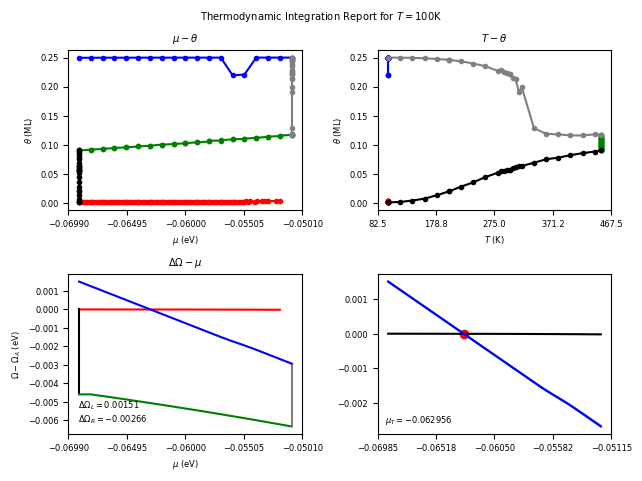

-0.06295616706166894 0.0006253249407496586 0.24985993501185008


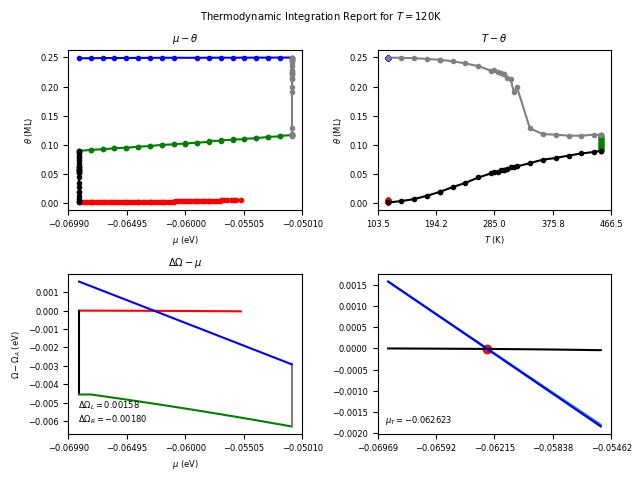

-0.06262285953065982 0.002768089151400385 0.24937257117486739


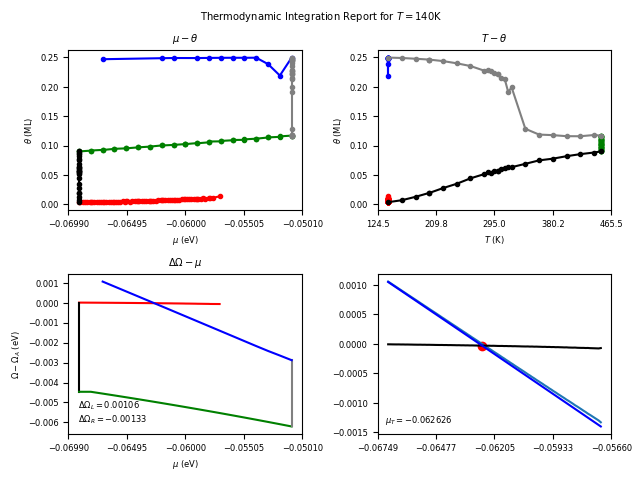

-0.06262576568479993 0.006349880593689964 0.24820739304585002


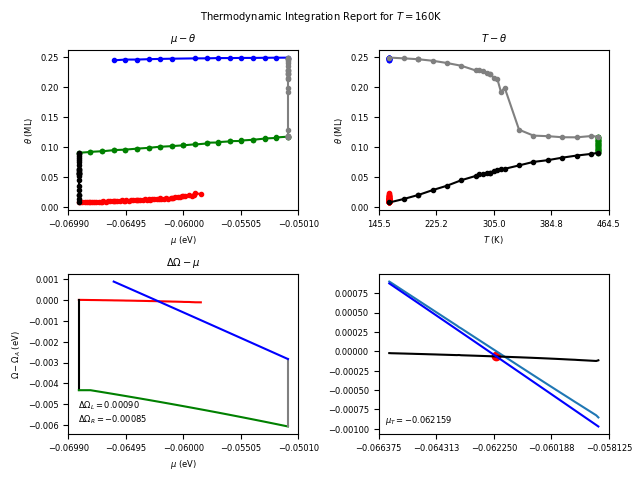

-0.06215902545845973 0.012849326546653292 0.24650960437999314


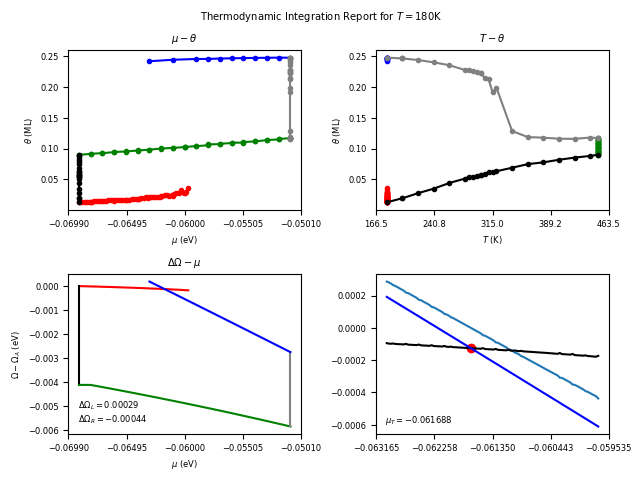

-0.06168845639071349 0.023971355677180034 0.2431523163410157


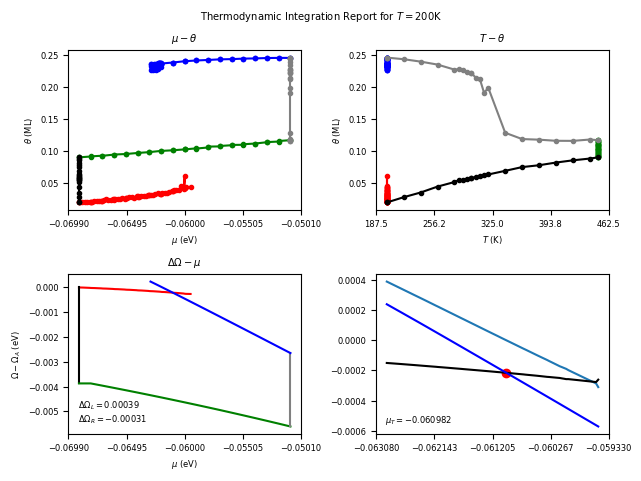

-0.0609824448328447 0.03712590247477637 0.2383965578299411

T=220K: insufficient data for thermodynamic integration.
   Max mu in branch AB is -0.0595 eV.
   Min mu in branch DC is -0.059 eV.


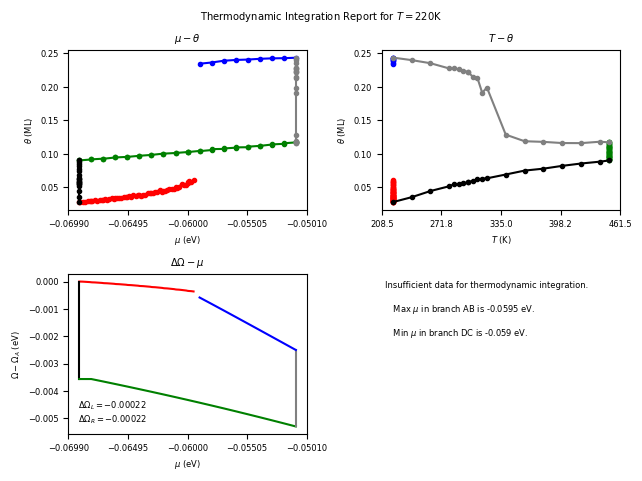

-0.05925 0.03712590247477637 0.2383965578299411


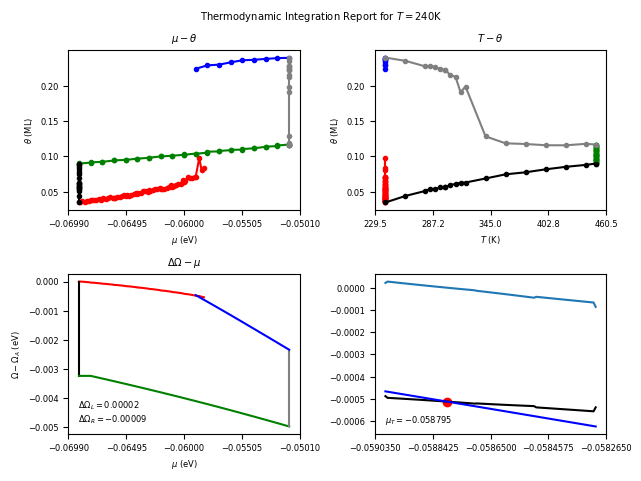

-0.05879486860165108 0.08963586947509089 0.22488350930837253

T=260K: insufficient data for thermodynamic integration.
   Max mu in branch AB is -0.0571 eV.
   Min mu in branch DC is -0.057 eV.


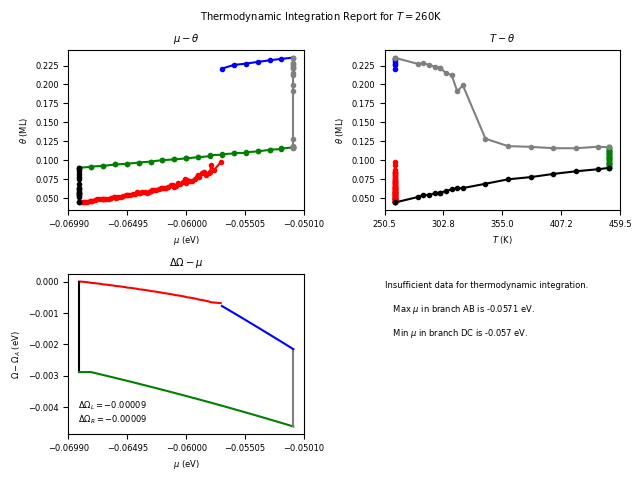

-0.057050000000000003 0.08963586947509089 0.22488350930837253

T=280K: insufficient data for thermodynamic integration.
   Max mu in branch AB is -0.0561 eV.
   Min mu in branch DC is -0.055 eV.


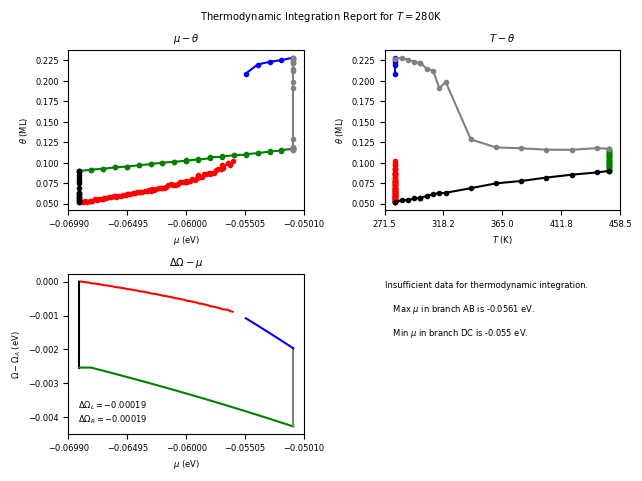

-0.05555 0.08963586947509089 0.22488350930837253

T=300K: insufficient data for thermodynamic integration.
   Max mu in branch AB is -0.0543 eV.
   Min mu in branch DC is -0.052 eV.


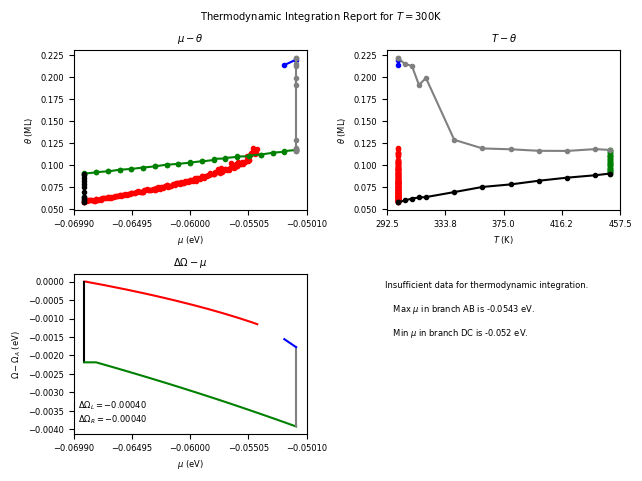

-0.05315 0.08963586947509089 0.22488350930837253


In [16]:
# Phase diagram: Loop over temperatures
Toi  = [100,120,140,160,180,200,220,240,260,280,300]
muL = [ -0.069, -0.069, -0.069, -0.069, -0.069, -0.069, -0.069, -0.069, -0.069, -0.069, -0.069]
muR = [ -0.051, -0.051, -0.051, -0.051, -0.051, -0.051, -0.051, -0.051, -0.051, -0.051, -0.051]
Tref = 450
cov_split = 0.125
cov0_low  = 0.01
cov0_high = 0.3
max_cov_span = 0.1

muTs = np.zeros(len(Toi))
cov_low  = np.zeros(len(Toi))
cov_high = np.zeros(len(Toi))
for i,T in enumerate(Toi):
    # find the intergration limits
    dfs = df.loc[(df['gc_chempots_0']>=muL[i]) & (df['gc_chempots_0']<=muR[i])]

    # reference(supercritical) isotherm (E-F)
    dftmp = dfs.loc[(dfs["Temp"] == Tref)].sort_values('gc_chempots_0')
    mudataEF  = dftmp['gc_chempots_0'].values
    covdataEF = dftmp['coverage'].values

    # branch 1 (A-B)
    dftmp = dfs.loc[(dfs["Temp"]      == T) & 
                    (dfs["cov_0"]     == cov0_low) &
                    (dfs["coverage"]  <  cov_split) & 
                    (dfs["cov_span"]  <  max_cov_span)
                    ].sort_values('gc_chempots_0')
    mudataAB  = dftmp['gc_chempots_0'].values
    covdataAB = dftmp['coverage'].values

    # branch 2 (D-C)
    dftmp = dfs.loc[(dfs["Temp"]      == T) & 
                    (dfs["cov_0"]     == cov0_high) &
                    (dfs["coverage"]  >  cov_split) & 
                    (dfs["cov_span"]  <  max_cov_span)
                    ].sort_values('gc_chempots_0')
    mudataDC  = dftmp['gc_chempots_0'].values
    covdataDC = dftmp['coverage'].values

    # A -> E iso-mu
    dftmp = dfs.loc[(dfs["Temp"] <= Tref) & (dfs["Temp"] >= T) &
                    (dfs["cov_0"]     == cov0_low) &
                    (dfs["gc_chempots_0"] == muL[i])
                    ].sort_values('Temp')
    TdataAE  = dftmp['Temp'].values
    covdataAE = dftmp['coverage'].values
    endataAE = dftmp['energy'].values

    # F -> D iso-mu
    dftmp = dfs.loc[(dfs["Temp"] <= Tref) & (dfs["Temp"] >= T) &
                    (dfs["cov_0"]     == cov0_low) &
                    (dfs["gc_chempots_0"] == muR[i])
                    ].sort_values('Temp')
    TdataFD  = dftmp['Temp'].values
    covdataFD = dftmp['coverage'].values
    endataFD = dftmp['energy'].values

    muT = (mudataAB[-1] + mudataDC[0])/2 + 0.000 + 1e-8
    
    # print(f'Omega_A = 0 ')
    # print(f'Omega_B = {Omega_B(muT,mudataAB,covdataAB):.5f}')
    # print(f'Omega_E = {Omega_E(muL[i],TdataAE,endataAE,covdataAE):.5f}')
    # print(f'Omega_F = {Omega_F(muL[i],muR[i],TdataAE,endataAE,covdataAE,
    #                     mudataEF,covdataEF):.5f}')
    # print(f'Omega_D = {Omega_D(muL[i],muR[i],TdataAE,endataAE,covdataAE,
    #                     mudataEF,covdataEF,
    #                     TdataFD,endataFD,covdataFD):.5f}')
    # print(f'Omega_C = {Omega_C(muT,muL[i],muR[i],TdataAE,endataAE,covdataAE,
    #                     mudataEF,covdataEF,
    #                     TdataFD,endataFD,covdataFD,
    #                     mudataDC,covdataDC):.5f}')

    plt.rcParams['font.size'] = 6
    fig, axis = plt.subplots(2,2)
    plt.suptitle(fr'Thermodynamic Integration Report for $T={T}$K')
    axis[0,0].set_title(fr'$\mu-\theta$')
    axis[0,0].set_xlabel(fr"$\mu$ (eV)")
    axis[0,0].set_ylabel(fr"$\theta$ (ML)")
    axis[0,1].set_title(fr'$T-\theta$')
    axis[0,1].set_xlabel(fr"$T$ (K)")
    axis[0,1].set_ylabel(fr"$\theta$ (ML)")
    #axis[0].set_xlim(muL,muR)
    #axis[0].set_ylim(.0,.26)

    axis[0,0].plot(mudataAB,covdataAB, marker='.',color='r', label="AB")
    axis[0,0].plot(mudataDC,covdataDC, marker='.',color='b', label="DC")
    axis[0,0].plot(mudataEF,covdataEF, marker='.',color='g', label="EF")
    axis[0,0].plot(muL[i]*np.ones(len(covdataAE)),covdataAE,color='k', marker='.', label="AE")
    axis[0,0].plot(muR[i]*np.ones(len(covdataFD)),covdataFD,color='grey', marker='.', label="FD")
    #axis[0].plot(muL*np.ones(2),np.array([coviB,coviDC]),'--')

    axis[0,1].plot(T   *np.ones(len(covdataAB)),covdataAB,color='r', marker='.', label="AB")
    axis[0,1].plot(T   *np.ones(len(covdataDC)),covdataDC,color='b', marker='.', label="DC")
    axis[0,1].plot(Tref*np.ones(len(covdataEF)),covdataEF,color='g', marker='.', label="EF")
    axis[0,1].plot(TdataAE,covdataAE,color='k', marker='.', label="AE")
    axis[0,1].plot(TdataFD,covdataFD,color='grey', marker='.', label="FD")

    axis[1,0].set_title(fr'$\Delta\Omega-\mu$')
    axis[1,0].set_xlabel(fr"$\mu$ (eV)")
    axis[1,0].set_ylabel(fr"$\Omega-\Omega_A$ (eV)")
    # axis.set_xlim(-.07,-.05)
    # axis.set_ylim(.0,.25)

    axis[1,0].plot(mudataAB,[Omega_B(mu,mudataAB,covdataAB) for mu in mudataAB], 'r-', label="AB")
    axis[1,0].plot([muL[i],muL[i]], [0,Omega_E(muL[i],TdataAE,endataAE,covdataAE)], 'k-', label="AE")
    axis[1,0].plot(mudataEF, [Omega_F(muL[i],mu,TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF) for mu in mudataEF] , '-',color='g', label="EF")
    axis[1,0].plot([muR[i],muR[i]], [Omega_F(muL[i],muR[i],TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF),Omega_D(muL[i],muR[i],TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF,
                        TdataFD,endataFD,covdataFD)], '-', color='grey', label="FD")
    axis[1,0].plot(mudataDC,[Omega_C(mu,muL[i],muR[i],TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF,
                        TdataFD,endataFD,covdataFD,
                        mudataDC,covdataDC) for mu in mudataDC], 'b-', label="DC")
    
    dOmegaCB = lambda mu: Omega_C(mu,muL[i],muR[i],TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF,
                        TdataFD,endataFD,covdataFD,
                        mudataDC,covdataDC) - Omega_B(mu,mudataAB,covdataAB)

    if (mudataAB[-1] <= mudataDC[0]):
        print(f'\nT={T}K: insufficient data for thermodynamic integration.')
        print(f'   Max mu in branch AB is {mudataAB[-1]} eV.')
        print(f'   Min mu in branch DC is {mudataDC[ 0]} eV.')

        dO_L = Omega_C(mudataDC[ 0],muL[i],muR[i],TdataAE,endataAE,covdataAE,
                        mudataEF,covdataEF,
                        TdataFD,endataFD,covdataFD,
                        mudataDC,covdataDC) - Omega_B(mudataAB[-1],mudataAB,covdataAB)
        dO_R = dO_L
        axis[1,1].axis('off'),
        plt.figtext(0.6, 0.4,fr'Insufficient data for thermodynamic integration.')
        plt.figtext(0.6,0.35,fr'   Max $\mu$ in branch AB is {mudataAB[-1]} eV.')
        plt.figtext(0.6,0.30,fr'   Min $\mu$ in branch DC is {mudataDC[ 0]} eV.')
    else:
        dO_L = dOmegaCB(mudataDC[0])
        dO_R = dOmegaCB(mudataAB[-1])

        mu_sol = fsolve(dOmegaCB,[muT])

        x = np.linspace(mudataDC[0],mudataAB[-1],100)
        axis[1,1].plot(x, [dOmegaCB(mu) for mu in x],label=fr'$\Delta\Omega$')
        axis[1,1].plot(x, [Omega_B(mu,mudataAB,covdataAB) for mu in x],'k-',label=fr'$\Omega_B$')
        axis[1,1].plot(x, [Omega_C(mu,muL[i],muR[i],TdataAE,endataAE,covdataAE,
                            mudataEF,covdataEF,
                            TdataFD,endataFD,covdataFD,
                            mudataDC,covdataDC) for mu in x],'b-',label=fr'$\Omega_C$')
        axis[1,1].scatter(mu_sol,[Omega_B(mu,mudataAB,covdataAB) for mu in mu_sol],color='r')
        plt.figtext(0.6,0.12,fr'$\mu_T = {mu_sol[0]:.6f}$')

    for ax in axis.flat:
#        ax.tick_params(axis='both', labelsize=6)
#        ax.xaxis.label.set_fontsize(8)
#        ax.yaxis.label.set_fontsize(8)
        ax.xaxis.set_major_locator(ticker.LinearLocator(5))

#    axis[0,0].legend()
    plt.figtext(0.12, 0.15,fr'$\Delta\Omega_L ={dO_L:.5f}$',)
    plt.figtext(0.12, 0.12,fr'$\Delta\Omega_R ={dO_R:.5f}$')

    plt.tight_layout()
    plt.show()

# Values to put on phase diagram

    if (mudataAB[-1] <= mudataDC[0]):
        mu_T = (mudataAB[-1] + mudataDC[0])/2
        cov_AB_T  = covdataAB[-1]
        cov_DC_T = covdataDC[0]
    else:
        mu_T = mu_sol[0]
        idx = np.where(mudataAB > mu_T)[0][0] - 1
        slope = (covdataAB[idx+1]-covdataAB[idx])/(mudataAB[idx+1]-mudataAB[idx])
        covAB_T = covdataAB[idx] + slope*(mu_T-mudataAB[idx])
        idx = np.where(mudataDC < mu_T)[0][-1]
        slope = (covdataDC[idx+1]-covdataDC[idx])/(mudataDC[idx+1]-mudataDC[idx])
        covDC_T = covdataDC[idx] + slope*(mu_T-mudataDC[idx])
    print(mu_T,covAB_T,covDC_T)
    muTs[i] = mu_T
    cov_low[i]  = covAB_T
    cov_high[i] = covDC_T

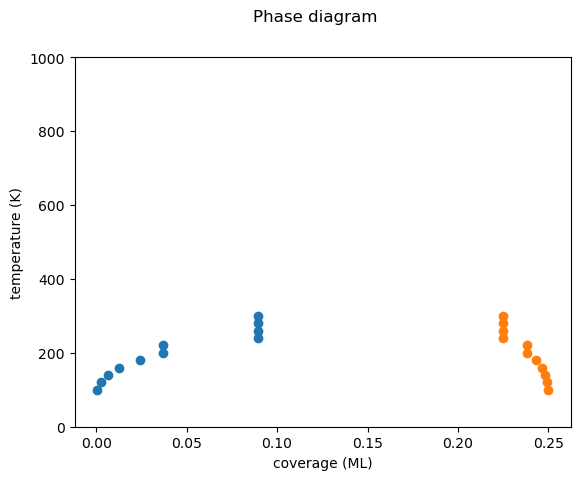

In [17]:
plt.rcParams['font.size'] = 10
fig,axis = plt.subplots()
plt.suptitle('Phase diagram')
axis.set_xlabel('coverage (ML)')
axis.set_ylabel('temperature (K)')

axis.scatter(cov_low, Toi)
axis.scatter(cov_high,Toi)

axis.set_ylim(0,1000)
plt.show()

In [ ]:
# The code below work but much slower then above

# Reading in trajectories and calculate averages
# start_eq = -500

# nenfiles = 0
# for d in datadirs:
#    nenfiles += len(list(d.glob('*.en')))
# pd_data = np.zeros((nenfiles,5))
# ifile = 0
# times = np.zeros(3)
# for i,d in enumerate(datadirs):
#     for enfile in d.glob('*.en'):
#         run_id = int(enfile.stem.split('-')[-1])
#         with open(enfile,'r') as f:
#             t1 = timer()
#             step,energy,nads = np.loadtxt(f,skiprows=1).transpose()
#             t2 = timer()
#             times[0] += t2 - t1
#             df1 = df.loc[ (df['run'] == run_id) & (df['logfile'] == logfiles[i]) ]
#             t1 = timer()
#             times[1] += t1 - t2
#             t2 = timer()
#             pd_data[ifile,0] = df1.Temp.iloc[0]
#             pd_data[ifile,1] = df1.mu_O.iloc[0]
#             pd_data[ifile,2] = df1.cov0_O.iloc[0]
#             pd_data[ifile,3] = nads[start_eq:].mean()/df1.ncells.iloc[0]
#             pd_data[ifile,4] = energy[start_eq:].mean()/df1.ncells.iloc[0]
#             times[0] += t2 - t1
#             ifile += 1
# print(f"{ifile} trajectories processed.")
# print(f"It took {np.sum(times):.2f} seconds:")
# print(f' {times[0]:.2f}s to load files')
# print(f' {times[1]:.2f}s to locate data in df')
# print(f' {times[2]:.2f}s to get averages')
# # %%

# fig, axis = plt.subplots()
# Toi = [220]
# axis.set_title(fr'$\theta$-$\mu$ phase diagram')
# axis.set_ylabel(fr"$\mu$ (eV)")
# axis.set_xlabel(fr"$\theta$ (ML)")
# mudata  = pd_data[np.where(pd_data[:,0]==220)][:,1]
# covdata = pd_data[np.where(pd_data[:,0]==220)][:,3]
# axis.plot(covdata,mudata,'k.')

# plt.show()

